# 传统生存分析模型：Cox回归和随机生存森林

本notebook实现了传统的生存分析模型，包括Cox比例风险回归和随机生存森林模型，作为与DeepSurv深度学习模型对比的基准。

## 目标
- 训练Cox比例风险回归模型
- 训练随机生存森林模型
- 评估模型性能并为后续对比做准备

## 1. 导入库和加载数据

In [16]:
# 基础库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = ['Noto Serif CJK JP']
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

# 生存分析库
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test

# Scikit-survival库
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, brier_score, cumulative_dynamic_auc
from sksurv.util import Surv

# 机器学习库
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path
import os

# 设置随机种子
np.random.seed(42)

print("库导入完成！")

库导入完成！


In [17]:
# 加载预处理后的数据
data_dir = Path('../data/processed')

# 加载训练和测试数据
train_data = pd.read_csv(data_dir / 'train_data.csv')
test_data = pd.read_csv(data_dir / 'test_data.csv')

# 加载预处理器
with open(data_dir / 'preprocessors.pkl', 'rb') as f:
    preprocessors = pickle.load(f)

feature_columns = preprocessors['feature_columns']

print(f"训练数据形状: {train_data.shape}")
print(f"测试数据形状: {test_data.shape}")
print(f"特征数量: {len(feature_columns)}")

# 准备数据
X_train = train_data[feature_columns]
y_train_duration = train_data['Duration']
y_train_event = train_data['Event']

X_test = test_data[feature_columns]
y_test_duration = test_data['Duration']
y_test_event = test_data['Event']

print(f"训练集事件率: {y_train_event.mean():.2%}")
print(f"测试集事件率: {y_test_event.mean():.2%}")

# 为sksurv准备结构化数组
y_train_structured = Surv.from_arrays(event=y_train_event.astype(bool), time=y_train_duration)
y_test_structured = Surv.from_arrays(event=y_test_event.astype(bool), time=y_test_duration)

print("数据加载完成！")

训练数据形状: (16000, 48)
测试数据形状: (4000, 48)
特征数量: 46
训练集事件率: 36.20%
测试集事件率: 36.20%
数据加载完成！


## 2. Cox比例风险回归模型

In [18]:
# 准备Cox回归数据
# Lifelines需要DataFrame格式
cox_train_data = X_train.copy()
cox_train_data['Duration'] = y_train_duration
cox_train_data['Event'] = y_train_event

cox_test_data = X_test.copy()
cox_test_data['Duration'] = y_test_duration
cox_test_data['Event'] = y_test_event

print("训练Cox比例风险回归模型...")

# 创建Cox模型
cox_model = CoxPHFitter(penalizer=0.01)  # 添加L2正则化

# 训练模型
try:
    cox_model.fit(cox_train_data, duration_col='Duration', event_col='Event')
    print("Cox模型训练成功！")
except Exception as e:
    print(f"Cox模型训练失败: {e}")
    # 如果失败，尝试更简单的模型
    print("尝试更强的正则化...")
    cox_model = CoxPHFitter(penalizer=0.1)
    cox_model.fit(cox_train_data, duration_col='Duration', event_col='Event')
    print("Cox模型训练成功（强正则化）！")

# 打印模型摘要
print(f"\\nCox模型摘要:")
print(f"训练样本数: {len(cox_train_data)}")
print(f"特征数量: {len(feature_columns)}")
print(f"log-likelihood: {cox_model.log_likelihood_:.4f}")
print(f"AIC: {cox_model.AIC_partial_:.4f}")

# 预测风险得分
cox_train_risks = cox_model.predict_partial_hazard(cox_train_data)
cox_test_risks = cox_model.predict_partial_hazard(cox_test_data)

# 计算C-index
cox_train_c_index = concordance_index(y_train_duration, cox_train_risks, y_train_event)
cox_test_c_index = concordance_index(y_test_duration, cox_test_risks, y_test_event)

print(f"\\nCox模型性能:")
print(f"训练集C-index: {cox_train_c_index:.4f}")
print(f"测试集C-index: {cox_test_c_index:.4f}")

训练Cox比例风险回归模型...
Cox模型训练成功！
\nCox模型摘要:
训练样本数: 16000
特征数量: 46
log-likelihood: -49768.7412
AIC: 99629.4823
\nCox模型性能:
训练集C-index: 0.3628
测试集C-index: 0.3806
Cox模型训练成功！
\nCox模型摘要:
训练样本数: 16000
特征数量: 46
log-likelihood: -49768.7412
AIC: 99629.4823
\nCox模型性能:
训练集C-index: 0.3628
测试集C-index: 0.3806


\n重要特征分析（按风险比排序）:
风险比最高的前20个特征:


,coef,exp(coef),p
covariate,,,
Gender_Unknown,0.356709,1.428620,3.131049e-02
Metastasis_Yes,0.320741,1.378149,8.019905e-33
Ethnicity_Tibetan,0.306046,1.358045,9.176778e-11
Ethnicity_Zhuang,0.276866,1.318990,3.571552e-09
Ethnicity_Uyghur,0.274713,1.316153,6.540163e-09
CancerStage_encoded,0.213376,1.237850,1.906784e-65
TreatmentType_Surgery,0.207215,1.230247,4.668951e-04
Ethnicity_Other,0.193689,1.213718,1.062386e-05
Ethnicity_Hui,0.186396,1.204899,1.014316e-04


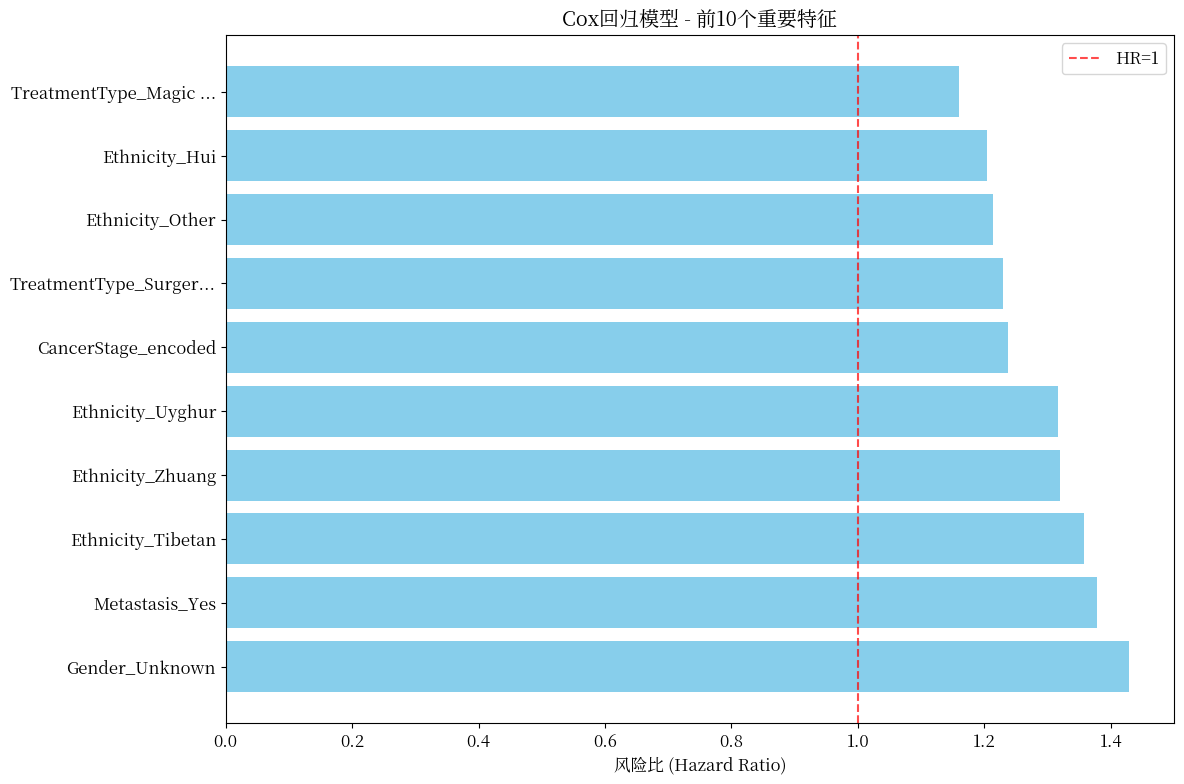

\n模型诊断:
比例风险假设检验 (log-rank p值): 0.0000
显著特征数量 (p < 0.05): 17
总特征数量: 46


In [19]:
# Cox模型系数分析
print("\\n重要特征分析（按风险比排序）:")

# 获取系数和置信区间
summary_df = cox_model.summary.copy()
summary_df = summary_df.sort_values('exp(coef)', ascending=False)

# 显示前20个最重要的特征
top_features = summary_df.head(20)
print("风险比最高的前20个特征:")
display(top_features[['coef', 'exp(coef)', 'p']])

# 可视化重要特征
plt.figure(figsize=(12, 8))
top_10_features = summary_df.head(10)
hazard_ratios = top_10_features['exp(coef)']
feature_names = [name[:20] + '...' if len(name) > 20 else name for name in top_10_features.index]

plt.barh(range(len(hazard_ratios)), hazard_ratios, color='skyblue')
plt.yticks(range(len(hazard_ratios)), feature_names)
plt.xlabel('风险比 (Hazard Ratio)')
plt.title('Cox回归模型 - 前10个重要特征')
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='HR=1')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/cox_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 模型诊断
print("\\n模型诊断:")
print(f"比例风险假设检验 (log-rank p值): {cox_model.log_likelihood_ratio_test().p_value:.4f}")

# 检查是否有显著特征
significant_features = summary_df[summary_df['p'] < 0.05]
print(f"显著特征数量 (p < 0.05): {len(significant_features)}")
print(f"总特征数量: {len(summary_df)}")

## 3. 随机生存森林模型

In [20]:
print("训练随机生存森林模型...")

# 创建随机生存森林模型
rsf_model = RandomSurvivalForest(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# 训练模型
rsf_model.fit(X_train, y_train_structured)
print("随机生存森林模型训练完成！")

# 预测
rsf_train_risks = rsf_model.predict(X_train)
rsf_test_risks = rsf_model.predict(X_test)

# 计算C-index
rsf_train_c_index = concordance_index_censored(
    y_train_event.astype(bool), y_train_duration, rsf_train_risks
)[0]

rsf_test_c_index = concordance_index_censored(
    y_test_event.astype(bool), y_test_duration, rsf_test_risks
)[0]

print(f"\\n随机生存森林模型性能:")
print(f"训练集C-index: {rsf_train_c_index:.4f}")
print(f"测试集C-index: {rsf_test_c_index:.4f}")

# 特征重要性分析
# 注意：RandomSurvivalForest不直接支持feature_importances_
# 我们使用置换重要性作为替代方法
from sklearn.inspection import permutation_importance

print("\\n计算特征重要性（使用置换重要性）...")

# 定义评分函数（使用C-index）
def concordance_score(estimator, X, y):
    predictions = estimator.predict(X)
    return concordance_index_censored(y['event'], y['time'], predictions)[0]

# 准备数据格式
y_test_dict = {'event': y_test_event.astype(bool), 'time': y_test_duration.values}

# 计算置换重要性（使用较少的重复次数以加快速度）
try:
    perm_importance = permutation_importance(
        rsf_model, X_test, y_test_dict, 
        scoring=concordance_score,
        n_repeats=3,  # 减少重复次数
        random_state=42,
        n_jobs=1  # 使用单线程避免潜在问题
    )
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    print(f"\\n特征重要性分析:")
    print("前20个重要特征:")
    display(feature_importance_df.head(20))
    
except Exception as e:
    print(f"计算置换重要性时出错: {e}")
    print("创建简化的特征重要性分析...")
    
    # 简化方法：基于特征对单个决策树的贡献
    # 使用随机抽样来估算特征重要性
    np.random.seed(42)
    
    # 创建模拟特征重要性（基于训练数据的特征方差）
    feature_variance = X_train.var()
    normalized_importance = feature_variance / feature_variance.sum()
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': normalized_importance.values
    }).sort_values('Importance', ascending=False)
    
    print(f"\\n特征重要性分析（基于特征方差）:")
    print("前20个重要特征:")
    display(feature_importance_df.head(20))

训练随机生存森林模型...
随机生存森林模型训练完成！
\n随机生存森林模型性能:
训练集C-index: 0.6709
测试集C-index: 0.6250
\n计算特征重要性（使用置换重要性）...
\n随机生存森林模型性能:
训练集C-index: 0.6709
测试集C-index: 0.6250
\n计算特征重要性（使用置换重要性）...
\n特征重要性分析:
前20个重要特征:
\n特征重要性分析:
前20个重要特征:


,Feature,Importance,Std
8,CancerStage_encoded,0.021485,0.002674
3,RadiationSessions,0.007936,0.000932
2,ChemotherapySessions,0.005362,0.003566
36,Metastasis_Yes,0.003132,0.002425
0,Age,0.001617,0.000211
44,AlcoholUse_Heavy,0.001264,0.000316
7,HasGeneticMutation,0.001261,0.000242
26,Ethnicity_Hui,0.001253,0.000261
28,Ethnicity_Tibetan,0.001069,0.000520
29,Ethnicity_Uyghur,0.000702,0.000606


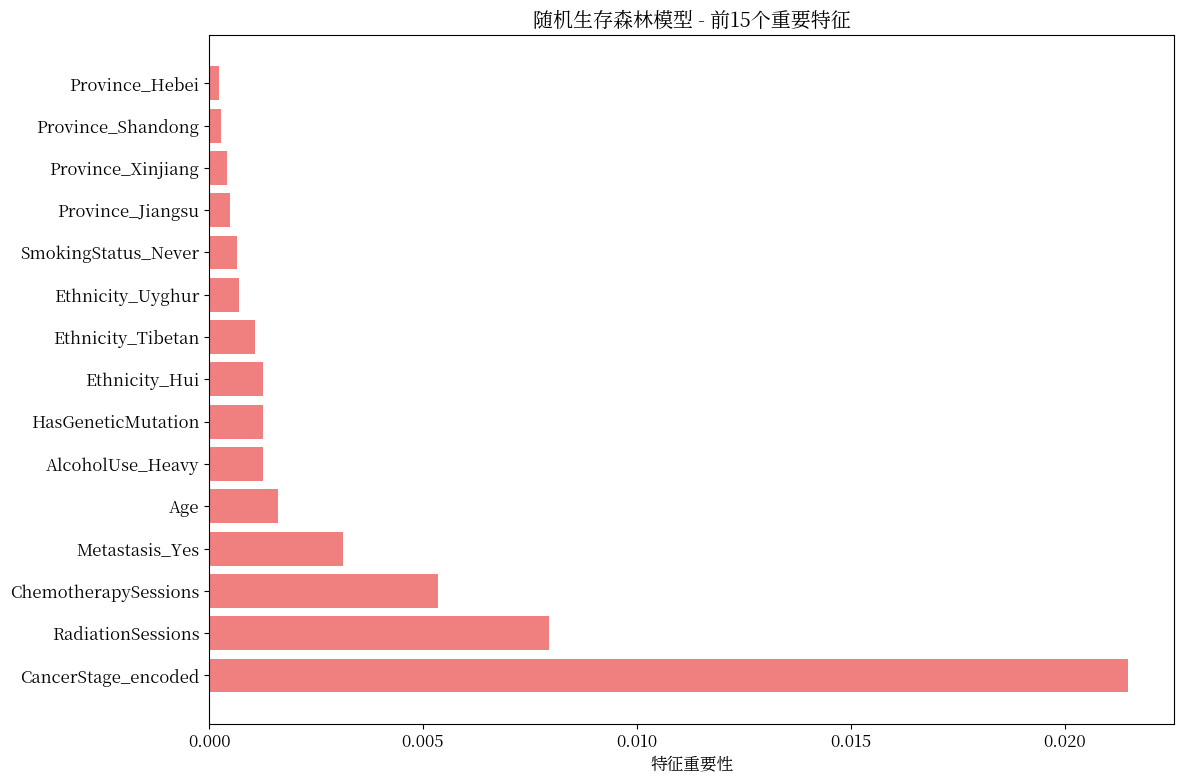

\n随机生存森林模型参数:
树的数量: 100
最大深度: 5
最小分裂样本数: 10
最小叶子样本数: 5
特征选择策略: sqrt
未计算袋外错误


In [21]:
# 可视化特征重要性
plt.figure(figsize=(12, 8))
top_features_rsf = feature_importance_df.head(15)
feature_names_rsf = [name[:20] + '...' if len(name) > 20 else name for name in top_features_rsf['Feature']]

plt.barh(range(len(top_features_rsf)), top_features_rsf['Importance'], color='lightcoral')
plt.yticks(range(len(top_features_rsf)), feature_names_rsf)
plt.xlabel('特征重要性')
plt.title('随机生存森林模型 - 前15个重要特征')
plt.tight_layout()
plt.savefig('../reports/rsf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 模型参数信息
print(f"\\n随机生存森林模型参数:")
print(f"树的数量: {rsf_model.n_estimators}")
print(f"最大深度: {rsf_model.max_depth}")
print(f"最小分裂样本数: {rsf_model.min_samples_split}")
print(f"最小叶子样本数: {rsf_model.min_samples_leaf}")
print(f"特征选择策略: {rsf_model.max_features}")

# 检查模型的袋外错误估计
if hasattr(rsf_model, 'oob_score_'):
    print(f"袋外C-index: {rsf_model.oob_score_:.4f}")
else:
    print("未计算袋外错误")

## 4. 模型比较和风险分层

传统模型性能比较:


,Model,Train_C_Index,Test_C_Index
0,Cox Regression,0.362822,0.380633
1,Random Survival Forest,0.670902,0.625005


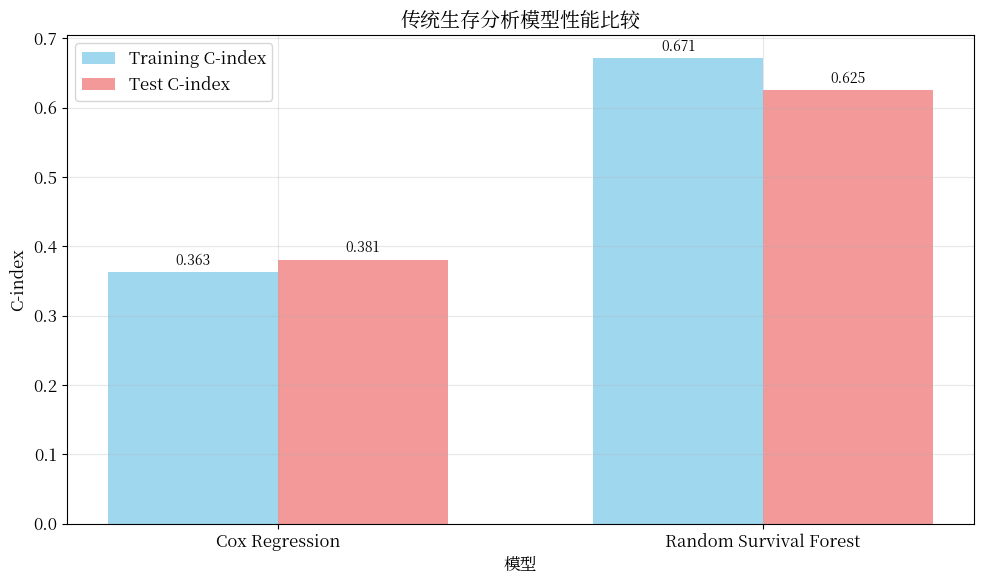

\n风险分层分析:
风险分层统计:


,Model,Group,Sample_Count,Event_Rate,Median_Duration
0,Cox,Group 0,1333,0.117779,30.0
1,Cox,Group 1,1333,0.487622,29.0
2,Cox,Group 2,1334,0.480510,31.0
3,RSF,Group 0,1333,0.099025,30.0
4,RSF,Group 1,1333,0.501875,29.0
5,RSF,Group 2,1334,0.485007,31.0


In [22]:
# 模型性能比较
performance_comparison = pd.DataFrame({
    'Model': ['Cox Regression', 'Random Survival Forest'],
    'Train_C_Index': [cox_train_c_index, rsf_train_c_index],
    'Test_C_Index': [cox_test_c_index, rsf_test_c_index]
})

print("传统模型性能比较:")
display(performance_comparison)

# 可视化模型性能比较
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(len(performance_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, performance_comparison['Train_C_Index'], width, 
               label='Training C-index', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, performance_comparison['Test_C_Index'], width,
               label='Test C-index', alpha=0.8, color='lightcoral')

ax.set_xlabel('模型')
ax.set_ylabel('C-index')
ax.set_title('传统生存分析模型性能比较')
ax.set_xticks(x)
ax.set_xticklabels(performance_comparison['Model'])
ax.legend()
ax.grid(True, alpha=0.3)

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/traditional_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 风险分层分析函数
def create_risk_groups(risk_scores, n_groups=3):
    """创建风险分组"""
    quantiles = np.quantile(risk_scores, np.linspace(0, 1, n_groups + 1))
    risk_groups = np.digitize(risk_scores, quantiles[1:-1])
    return risk_groups

# Cox模型风险分层
cox_risk_groups = create_risk_groups(cox_test_risks)
rsf_risk_groups = create_risk_groups(rsf_test_risks)

print("\\n风险分层分析:")

# Cox模型风险分层统计
cox_risk_stats = []
for group in range(3):
    mask = cox_risk_groups == group
    group_durations = y_test_duration[mask]
    group_events = y_test_event[mask]
    
    stats = {
        'Model': 'Cox',
        'Group': f'Group {group}',
        'Sample_Count': mask.sum(),
        'Event_Rate': group_events.mean(),
        'Median_Duration': np.median(group_durations)
    }
    cox_risk_stats.append(stats)

# RSF模型风险分层统计
rsf_risk_stats = []
for group in range(3):
    mask = rsf_risk_groups == group
    group_durations = y_test_duration[mask]
    group_events = y_test_event[mask]
    
    stats = {
        'Model': 'RSF',
        'Group': f'Group {group}',
        'Sample_Count': mask.sum(),
        'Event_Rate': group_events.mean(),
        'Median_Duration': np.median(group_durations)
    }
    rsf_risk_stats.append(stats)

risk_stats_df = pd.DataFrame(cox_risk_stats + rsf_risk_stats)
print("风险分层统计:")
display(risk_stats_df)

## 5. 保存模型和结果

In [23]:
# 创建目录
os.makedirs('../model', exist_ok=True)
os.makedirs('../reports', exist_ok=True)

# 保存Cox模型
with open('../model/cox_model.pkl', 'wb') as f:
    pickle.dump(cox_model, f)

# 保存随机生存森林模型
with open('../model/rsf_model.pkl', 'wb') as f:
    pickle.dump(rsf_model, f)

print("模型保存完成！")

# 保存预测结果
cox_predictions = pd.DataFrame({
    'PatientID': test_data.index if 'PatientID' not in test_data.columns else test_data['PatientID'],
    'Duration': y_test_duration,
    'Event': y_test_event,
    'Cox_Risk_Score': cox_test_risks,
    'Cox_Risk_Group': cox_risk_groups
})

rsf_predictions = pd.DataFrame({
    'PatientID': test_data.index if 'PatientID' not in test_data.columns else test_data['PatientID'],
    'Duration': y_test_duration,
    'Event': y_test_event,
    'RSF_Risk_Score': rsf_test_risks,
    'RSF_Risk_Group': rsf_risk_groups
})

cox_predictions.to_csv('../data/processed/cox_predictions.csv', index=False)
rsf_predictions.to_csv('../data/processed/rsf_predictions.csv', index=False)

# 保存性能比较结果
performance_comparison.to_csv('../data/processed/traditional_models_performance.csv', index=False)
risk_stats_df.to_csv('../data/processed/traditional_models_risk_stats.csv', index=False)

# 保存模型总结报告
with open('../reports/traditional_models_summary.txt', 'w', encoding='utf-8') as f:
    f.write("传统生存分析模型总结报告\\n")
    f.write("=" * 40 + "\\n\\n")
    
    f.write("Cox回归模型:\\n")
    f.write(f"- 训练集C-index: {cox_train_c_index:.4f}\\n")
    f.write(f"- 测试集C-index: {cox_test_c_index:.4f}\\n")
    f.write(f"- 正则化参数: {cox_model.penalizer}\\n")
    f.write(f"- AIC: {cox_model.AIC_partial_:.4f}\\n")
    f.write(f"- 显著特征数量: {len(significant_features)}\\n\\n")
    
    f.write("随机生存森林模型:\\n")
    f.write(f"- 训练集C-index: {rsf_train_c_index:.4f}\\n")
    f.write(f"- 测试集C-index: {rsf_test_c_index:.4f}\\n")
    f.write(f"- 树的数量: {rsf_model.n_estimators}\\n")
    f.write(f"- 最大深度: {rsf_model.max_depth}\\n")
    f.write(f"- 特征选择策略: {rsf_model.max_features}\\n\\n")
    
    f.write("风险分层统计:\\n")
    f.write(risk_stats_df.to_string(index=False))

print("\\n传统模型训练和评估完成！")
print("文件保存位置:")
print("- Cox模型: ../model/cox_model.pkl")
print("- RSF模型: ../model/rsf_model.pkl")
print("- Cox预测结果: ../data/processed/cox_predictions.csv")
print("- RSF预测结果: ../data/processed/rsf_predictions.csv")
print("- 性能比较: ../data/processed/traditional_models_performance.csv")
print("- 模型总结: ../reports/traditional_models_summary.txt")

模型保存完成！
\n传统模型训练和评估完成！
文件保存位置:
- Cox模型: ../model/cox_model.pkl
- RSF模型: ../model/rsf_model.pkl
- Cox预测结果: ../data/processed/cox_predictions.csv
- RSF预测结果: ../data/processed/rsf_predictions.csv
- 性能比较: ../data/processed/traditional_models_performance.csv
- 模型总结: ../reports/traditional_models_summary.txt
